In [1]:
#setup credentials for OpenTargets API
from google.cloud import bigquery
credentials_path = './test-bigquery-ot-f74b72249530.json'
client = bigquery.Client.from_service_account_json(credentials_path)

In [2]:
#Other imports
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# Pull in the 1000 genomes pedigree information from a public BigQuery table
query = '''
SELECT *
FROM `bigquery-public-data.human_genome_variants.1000_genomes_pedigree`
'''

# Run the query
query_job = client.query(query)

# Get the results as a pandas dataframe
ped = query_job.to_dataframe()
ped

,Family_ID,Individual_ID,Paternal_ID,Maternal_ID,Gender,Phenotype,Population,Relationship,Siblings,Second_Order,Third_Order,Other_Comments
0,1463,NA12877,NA12889,NA12890,1,0,CEU,father; child,0,0,0,0
1,2395,NA19742,NA19741,NA19740,1,0,MXL,child of 19740,0,0,0,0
2,ST006,HG04215,HG03679,HG03642,1,0,STU,Child2,0,0,0,0
3,GBR001,HG00155,0,HG00144,1,0,GBR,Child,0,0,0,0
4,IT006,HG03879,0,HG03874,1,0,ITU,Child2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3496,1444,NA12749,0,0,2,0,CEU,pat grandmother,0,0,0,0
3497,1447,NA12761,0,0,2,0,CEU,pat grandmother,0,0,0,0
3498,1451,NA12776,0,0,2,0,CEU,pat grandmother,0,0,0,0
3499,1456,NA12828,0,0,2,0,CEU,pat grandmother,0,0,0,0


In [4]:
#get a smaller pedigree to play with
ped.groupby("Family_ID").count().sort_values("Individual_ID", ascending=False)

,Individual_ID,Paternal_ID,Maternal_ID,Gender,Phenotype,Population,Relationship,Siblings,Second_Order,Third_Order,Other_Comments
Family_ID,,,,,,,,,,,
1463,6,6,6,6,6,6,6,6,6,6,6
1350,6,6,6,6,6,6,6,6,6,6,6
1459,6,6,6,6,6,6,6,6,6,6,6
1456,6,6,6,6,6,6,6,6,6,6,6
1454,6,6,6,6,6,6,6,6,6,6,6
...,...,...,...,...,...,...,...,...,...,...,...
NA18957,1,1,1,1,1,1,1,1,1,1,1
NA18956,1,1,1,1,1,1,1,1,1,1,1
NA18955,1,1,1,1,1,1,1,1,1,1,1


In [5]:
def plot_pedigree(ped_file, family_id):

    """
    Builds a directed graph in NetworkX that represents a pedigree from a .ped file.

    Parameters:
    ped_file_path (str): The path to the .ped file.

    Returns:
    Plot of the pedigree graph, where each node represents an individual and
                          each edge represents a parent-child relationship.
    """
    
    ped_file=ped_file.query(f'Family_ID=="{family_id}"')
    
    #get lists from the pedigree file
    ids = ped_file.iloc[:,1].tolist()
    father_ids = ped_file.iloc[:,2].tolist()
    mother_ids = ped_file.iloc[:,3].tolist()
    sexes = ped_file.iloc[:,4].tolist()

    #create an empty directional graph
    G = nx.DiGraph()

    # Add the nodes to the graph, color by sex
    for i in range(len(ids)):
        sex = sexes[i]
        color = "blue" if sex == 1 else "pink" # use "blue" for males and "pink" for females
        G.add_node(ids[i], sex=sex, color=color)

    #Add the edges to the graph
    for i in range(len(ids)):
        father = father_ids[i]
        mother = mother_ids[i]
        if father != "0":
            G.add_edge(father, ids[i])
        if mother != "0":
            G.add_edge(mother, ids[i])
    
    # Draw the graph with node colors based on their sex
    pos = nx.spring_layout(G)
    node_colors = [G.nodes[n]["color"] for n in G.nodes]
    nx.draw(G, pos, node_color=node_colors, with_labels=True)
    
    #return(G)
    plt.show()

In [6]:
#we'll use family 1350, which has 6 members for a quick demo
small_ped=ped.query("Family_ID=='1350'")
small_ped

,Family_ID,Individual_ID,Paternal_ID,Maternal_ID,Gender,Phenotype,Population,Relationship,Siblings,Second_Order,Third_Order,Other_Comments
878,1350,NA10856,NA11829,NA11830,1,0,CEU,father,0,0,0,0
1695,1350,NA11831,0,0,1,0,CEU,mat grandfather,0,0,0,0
1722,1350,NA11829,0,0,1,0,CEU,pat grandfather,0,0,0,0
2621,1350,NA10855,NA11831,NA11832,2,0,CEU,mother,0,0,0,0
3453,1350,NA11832,0,0,2,0,CEU,mat grandmother,0,0,0,0
3484,1350,NA11830,0,0,2,0,CEU,pat grandmother,0,0,0,0


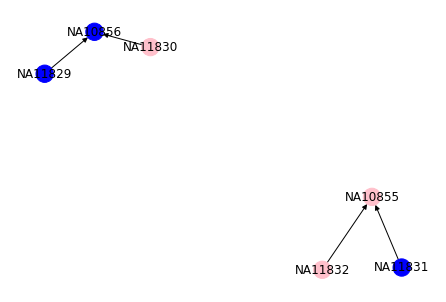

In [7]:
plot_pedigree(ped_file=ped, family_id=1350)